# Growing Neural Modules

## Import

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import mediapy
import optax
from cax.core.ca import UnsupervisedCA
from cax.core.perceive.dwconv_perceive import DWConvPerceive
from cax.core.perceive.kernels import grad_kernel, identity_kernel
from cax.core.state import state_to_alive
from cax.core.update.nca_update import NCAUpdate
from cax.nn.pool import Pool
from cax.nn.vae import Encoder
from datasets import load_dataset
from flax import nnx
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import wandb
import PIL

import augmax

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
task_type = "transform"

seed = 0
n_classes = 10
n_tasks = 1

# Encode task or input into intial seed
task_in_seed = False
input_in_seed = False
# Encode input into initial seed using encoder
encode_in_seed = False


# Provide context to CA
task_in_context = True
input_in_context = False
# Encode context using encoder
encode_in_context = True

task_context_size = n_tasks if task_type == "artithmetic" else 5

# encoder takes 2 images as input
spatial_dims = (28, 28)
features = (2 if task_type == "artithmetic" else 1, 32, 32)
latent_size = 10

channel_size = 64
num_kernels = 3
hidden_size = 512
cell_dropout_rate = 0.5

context_size = (
    latent_size * encode_in_context
    + n_classes * input_in_context
    + task_context_size * task_in_context
)

pool_size = 1_024
batch_size = 8
replace_size = 2
num_steps = 64
learning_rate = 1e-3

key = jax.random.PRNGKey(seed)
rngs = nnx.Rngs(seed)

tasks = {0: "id_0", 1: "id_1", 2: "add", 3: "mul", 4: "sub", 5: "xor"}

config = {
    "task_type": task_type,
    "seed": seed,
    "n_classes": n_classes,
    "n_tasks": n_tasks,
    "spatial_dims": spatial_dims,
    "features": features,
    "latent_size": latent_size,
    "channel_size": channel_size,
    "hidden_size": hidden_size,
    "cell_dropout_rate": cell_dropout_rate,
    "pool_size": pool_size,
    "replace_size": replace_size,
    "batch_size": batch_size,
    "num_steps": num_steps,
    "learning_rate": learning_rate,
}

2024-09-20 18:00:46.516261: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Dataset

In [4]:
ds = load_dataset("ylecun/mnist")

image_train = jnp.expand_dims(
    jnp.array(ds["train"]["image"], dtype=jnp.float32) / 255, axis=-1
)
image_test = jnp.expand_dims(
    jnp.array(ds["test"]["image"], dtype=jnp.float32) / 255, axis=-1
)

label_train = jnp.array(ds["train"]["label"])
label_test = jnp.array(ds["test"]["label"])

state_shape = image_train.shape[1:3] + (channel_size,)
mid = (size // 2 for size in state_shape[:-1])

mediapy.show_images(image_train[:8], width=64, height=64)

,,,,,,,


In [5]:
mediapy.write_image("image.png", jnp.squeeze(image_train[0]))

## Tasks

### Arithmetic

In [6]:
def id_0(x, y):
    return x


def id_1(x, y):
    return y


def add(x, y):
    return (x + y) % n_classes


def mul(x, y):
    return (x * y) % n_classes


def sub(x, y):
    return (x - y) % n_classes


def xor(x, y):
    return (x != y) % n_classes


def get_task_switch(task, *operands):
    return jax.lax.switch(task, [id_0, id_1, add, mul, sub, xor], *operands)

In [7]:
def get_arithmetic_task_target(key, target_1, target_2, task):

    key, target_key = jax.random.split(key)
    # print(target_1, target_2)
    target_label = get_task_switch(task, target_1, target_2)

    # Number of random samples to take for each corresponding label
    subset_size = 4

    # Get all the indexes where the label is equal to the target
    target_matches = jnp.where(label_train == target_label, size=label_train.shape[0])[
        0
    ]

    # Use dynamic_slice to get random instances
    random_index = jax.random.randint(
        target_key, (subset_size), 0, jnp.sum(label_train == target_label)
    )
    target_index = jax.vmap(
        lambda idx: jax.lax.dynamic_slice(target_matches, (idx,), (1,))
    )(random_index)
    target_index = target_index.squeeze()

    # Get the target image
    target = image_train[target_index]

    return target, jax.nn.one_hot(task, num_classes=n_tasks)

### Image transform

In [10]:
transform_dict = {
    "train": {
        "translate": [[0, spatial_dims[0] // 5], [-spatial_dims[1] // 5, 0]], 
        # "translate": [[0, 0], [0, 0]],
        "rotate": [0, 50],
        # "rotate": [0, 0],
        # "scale": [[1, 1.3], [0.9, 1]],
        # "scale": [[1, 1], [1, 1]],
    },
    "test": {
        "translate": [[-spatial_dims[0] // 3, 0], [0, spatial_dims[1] // 3]],
        "rotate": [-180, 0],
        # "scale": [0.7, 2],
    },
}

def image_transform(key, image, trial):

    key, *transform_keys = jax.random.split(key, 6)

    # t_image, [scale_x, scale_y] = image_scale(transform_keys[2], image, transforms[trial]["scale"])
    # t_image, [dx, dy] = image_translate(transform_keys[0], t_image, transforms[trial]["translate"])
    # t_image, theta = image_rotate(transform_keys[1], t_image, transforms[trial]["rotate"])

    transforms = []
    if "rotate" in transform_dict[trial]:
        transforms.append(
            augmax.Rotate(
                [
                    transform_dict[trial]["rotate"][0],
                    transform_dict[trial]["rotate"][1],
                ],
                p=1.0,
            )
        )
        theta = None
    else:
        theta = 0

    if "scale" in transform_dict[trial]:
        scale_x = jax.random.uniform(
            transform_keys[2],
            shape=(),
            minval=transform_dict[trial]["scale"][0][0],
            maxval=transform_dict[trial]["scale"][0][1],
        )
        scale_y = jax.random.uniform(
            transform_keys[3],
            shape=(),
            minval=transform_dict[trial]["scale"][1][0],
            maxval=transform_dict[trial]["scale"][1][1],
        )
        transforms.append(
            augmax.Resize(
                (spatial_dims[0] * scale_x).astype(int),
                (spatial_dims[1] * scale_y).astype(int),
            )
        )
        transforms.append(
            augmax.CenterCrop(spatial_dims[0], spatial_dims[1]),
        )
    else:
        scale_x, scale_y = 1, 1

    if "translate" in transform_dict[trial]:
        dx = jax.random.uniform(
            transform_keys[0],
            shape=(),
            minval=transform_dict[trial]["translate"][0][0],
            maxval=transform_dict[trial]["translate"][0][1],
        )
        dy = jax.random.uniform(
            transform_keys[1],
            shape=(),
            minval=transform_dict[trial]["translate"][1][0],
            maxval=transform_dict[trial]["translate"][1][1],
        )
        transforms.append(augmax.Translate(dx, dy))

    else:
        dx, dy = 0, 0

    transform_fn = augmax.GeometricChain(*transforms)

    t_image = transform_fn(transform_keys[-1], image)

    vars = {
        "dx": dx / spatial_dims[0],
        "dy": dy / spatial_dims[1],
        "theta": (
            transform_fn.transforms[0].theta / 180 if theta is None else theta 
        ),
        "scale_x": scale_x,
        "scale_y": scale_y,
    }
    print(vars["theta"])
    if "scale" in transform_dict[trial]:
        vars["scale_x"] /= transform_dict[trial]["scale"][0][1]
        vars["scale_y"] /= transform_dict[trial]["scale"][1][1]
    return t_image, vars

In [12]:
key, *tranform_keys = jax.random.split(key, 65)
t_images, vars = jax.vmap(lambda key, image: image_transform(key, image, "train"))(
    jnp.array(tranform_keys), image_train[:64]
)
mediapy.show_images(t_images.squeeze(), columns=8, return_html=False)

Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.27328902, 0.15312366, 0.03805634, 0.06461521, 0.08665506,
       0.02018028, 0.09980214, 0.25481334, 0.22821437, 0.09110258,
       0.12299258, 0.02743095, 0.02803398, 0.14096472, 0.07107486,
       0.02339883, 0.27114105, 0.0193028 , 0.24941005, 0.074325  ,
       0.05006519, 0.0048544 , 0.04299518, 0.05041619, 0.05074494,
       0.09037454, 0.07236581, 0.08212948, 0.18003403, 0.09309706,
       0.1839489 , 0.02287017, 0.16519915, 0.2750256 , 0.25699732,
       0.03827042, 0.25570583, 0.08155094, 0.12344871, 0.19236358,
       0.17606775, 0.22054084, 0.18423957, 0.14290932, 0.11574232,
       0.05378093, 0.21814276, 0.02535475, 0.04375521, 0.05364352,
       0.07969859, 0.14440425, 0.14768438, 0.15013373, 0.27314034,
       0.11836327, 0.03294561, 0.1348554 , 0.2108224 , 0.22129901,
       0.20718308, 0.2608435 , 0.2610756 , 0.0425663 ], dtype=float32)
  batch_dim = 0


,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,
,,,,,,,


In [13]:
def get_target(*args):

    if task_type == "artithmetic":
        target, task_context = get_arithmetic_task_target(*args)
    elif task_type == "transform":
        target, task_context = image_transform(*args)
        task_context = jnp.array(list(task_context.values()))
        # print(task_context.shape)
    else:
        raise ValueError(f"Task type {task_type} not supported")

    return target, task_context

## Init state

In [14]:
def init_state(key, ca=None, trial="train"):

    key, input_key, task_key, problem_key, encode_key = jax.random.split(key, 5)

    state_shape = image_train.shape[1:3] + (channel_size,)
    state = jnp.zeros(state_shape)
    mid = tuple(size // 2 for size in state_shape[:-1])

    input_index = jax.random.choice(
        input_key,
        image_train.shape[0] if trial == "train" else image_test.shape[0],
        shape=(2,) if task_type == "artithmetic" else (),
        replace=False,
    )
    if trial == "train":
        labels = label_train[input_index]
        print(labels)
        input_images = image_train[input_index]
    else:
        labels = label_test[input_index]
        print(labels)
        input_images = image_test[input_index]

    if task_type == "artithmetic":
        task = jax.random.choice(task_key, n_tasks)
        target, task_context = get_target(problem_key, *labels, task)
    elif task_type == "transform":
        task = None
        target, task_context = image_transform(problem_key, input_images, "train")
        task_context = jnp.array(list(task_context.values()))

    else:
        raise ValueError(f"Task type {task_type} not supported")

    # Set the "alive" cell
    state = state.at[mid + (channel_size - 1,)].set(1.0)

    def one_hot_input_into_seed(state):
        # print("One hot seed input")
        # encode targets into state
        one_hot_1 = jax.nn.one_hot(labels[0], num_classes=n_classes)
        one_hot_2 = jax.nn.one_hot(labels[1], num_classes=n_classes)
        # Set the one-hot encoded labels
        state = state.at[
            mid + (slice(channel_size - n_classes - 1, channel_size - 1),)
        ].set(one_hot_1)

        # If you want to set the second label as well, uncomment and adjust the following line:
        state = state.at[
            mid
            + (slice(channel_size - 2 * n_classes - 1, channel_size - n_classes - 1),)
        ].set(one_hot_2)

    def one_hot_task_into_seed(state):
        # print("One hot seed task")
        # encode task into state
        state = state.at[
            mid + (slice(channel_size - task_context_size - 1, channel_size - 1),)
        ].set(task_context)

    def encode_input_into_seed(state):
        # print("Encode seed")
        if ca is not None:
            # encode input into state
            if task_type == "artithmetic":
                input = jnp.concatenate([input_images[0], input_images[1]], axis=-1)
            else:
                input = input_images

            target_enc = ca.encode(input, encode_key)
            state = state.at[
                mid + (slice(channel_size - latent_size - 1, channel_size - 1),)
            ].set(target_enc)

    if task_in_seed:
        one_hot_task_into_seed(state)
    elif input_in_seed:
        one_hot_input_into_seed(state)
    elif encode_in_seed:
        encode_input_into_seed(state)

    return {
        "state": state,
        "target": target,
        # "task": task,
        "task_context": task_context,
        "input_index": input_index,
        "input_labels": labels,
        "input_images": input_images,
    }

## Model

In [15]:
def get_model():
    encoder = Encoder(spatial_dims, features, latent_size, rngs)
    perceive = DWConvPerceive(channel_size, rngs)
    update = NCAUpdate(
        channel_size,
        context_size + num_kernels * channel_size,
        (hidden_size,),
        rngs,
        cell_dropout_rate=cell_dropout_rate,
    )
    kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
    kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
    perceive.dwconv.kernel = nnx.Param(kernel)
    ca = UnsupervisedCA(perceive, update, encoder)
    params = nnx.state(ca, nnx.Param)
    print(
        "Number of params:",
        jax.tree_util.tree_reduce(lambda x, y: x + y.size, params, 0),
    )
    return ca

### Pool

In [16]:
def get_pool(key, ca=None):

    key, subkey = jax.random.split(key)

    keys = jax.random.split(subkey, pool_size)
    new_data = jax.vmap(
        lambda key: init_state(
            key,
            ca,
        )
    )(keys)

    pool = Pool.create(**new_data)
    return pool

### Optimizer

In [17]:
def get_optimizer(ca):
    lr_sched = optax.linear_schedule(
        init_value=learning_rate,
        end_value=0.1 * learning_rate,
        transition_steps=50_000,
    )
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=lr_sched),
    )
    grad_params = nnx.All(
        nnx.Param, nnx.Any(nnx.PathContains("update"), nnx.PathContains("encoder"))
    )
    optimizer = nnx.Optimizer(ca, optimizer, wrt=grad_params)
    return optimizer, grad_params

## Train

### Loss

In [18]:
def mse(state, target):
    if len(state.shape) != len(target.shape):
        loss = jax.vmap(lambda t: mse(state, t))(
            target.swapaxes(0, 1) if state.shape[0] == target.shape[0] else target
        )
    else:
        loss = jnp.square(state_to_alive(state) - target)

    return loss


@nnx.jit
def loss_fn(ca, state, target, input, label, task_context, key):

    key, randint_key, encode_key = jax.random.split(key, 3)

    def encode_context():
        if ca is not None:
            context = ca.encode(input, encode_key)
        else:
            context = jnp.zeros((batch_size, latent_size))

        return context

    def one_hot_input_label():
        context = jax.nn.one_hot(label[:, 0], num_classes=n_classes) + jax.nn.one_hot(
            label[:, 1], num_classes=n_classes
        )

        context = jnp.concatenate(
            [context, jnp.zeros((batch_size, context_size - n_classes))], axis=-1
        )
        return context


    context = jnp.zeros((batch_size, context_size))
    print(task_context)

    c_size = 0
    if encode_in_context:
        context = context.at[:, c_size : c_size + latent_size].set(encode_context())
        c_size += latent_size

    if task_in_context:
        context = context.at[:, c_size : c_size + task_context_size].set(
            task_context
        )
        c_size += task_context_size
    if input_in_context:
        context = context.at[:, c_size : c_size + n_classes].set(
            one_hot_input_label()
        )
        c_size += n_classes
    assert c_size == context.shape[-1] == context_size, "Context size mismatch"

    state = nnx.vmap(
        lambda state, context: ca(state, context, num_steps=num_steps, all_steps=True)
    )(state, context)

    index = jax.random.randint(
        randint_key, (state.shape[0],), num_steps // 2, num_steps
    )
    state = state[jnp.arange(state.shape[0]), index]

    loss = mse(state, target)
    # Add regularization loss to avoid null outputs

    # regularization_loss = jnp.mean(jnp.square(state_to_alive(state)))
    # loss += 1 * regularization_loss

    return loss.mean(), (state, loss)

### Train Step

In [19]:
@nnx.jit
def train_step(ca, optimizer, pool, key, batch_size=batch_size):

    sample_key, init_state_key, loss_key = jax.random.split(key, 3)

    # Sample from pool
    pool_index, sample = pool.sample(sample_key, sample_size=batch_size)

    current_data = {k: sample[k] for k in sample.keys()}
    current_target = current_data["target"]

    # Sort by descending loss
    sort_index = jnp.argsort(
        jax.vmap(lambda state, target: mse(state, target).mean())(
            current_data["state"], current_target
        ),
        descending=True,
    )
    pool_index = pool_index[sort_index]
    # current_data = {k: current_data[k][sort_index] for k in current_data.keys()}
    current_data = jax.tree.map(lambda x: x[sort_index], current_data)

    r_size = min(replace_size, batch_size)
    init_state_keys = jax.random.split(init_state_key, r_size)
    # Sample a new target to replace the worst
    new_data = jax.vmap(lambda key: init_state(key, ca))(init_state_keys)

    # for k in current_data.keys():
    #     current_data[k] = current_data[k].at[:r_size].set(new_data[k])
    
    # Update the worst performing samples with new data
    current_data = jax.tree.map(
        lambda cur, new: cur.at[:r_size].set(new),
        current_data,
        new_data
    )

    current_target = current_data["target"]
    current_label = label_train[current_data["input_index"]]
    current_task_context = current_data["task_context"]

    current_inputs = image_train[current_data["input_index"]]
    if task_type == "artithmetic":
        current_input = jnp.concatenate(
            [current_inputs[:, 0], current_inputs[:, 1]], axis=-1
        )
    else:
        current_input = current_inputs

    (loss, (current_state, complete_loss)), grad = nnx.value_and_grad(
        loss_fn,
        has_aux=True,
        argnums=nnx.DiffState(0, grad_params),
    )(
        ca,
        current_data["state"],
        current_target,
        current_input,
        current_label,
        current_task_context,
        loss_key,
    )

    current_data["state"] = current_state

    optimizer.update(grad)
    pool = pool.add(pool_index, **current_data)

    return loss, pool, grad, current_task_context, complete_loss

## Visualize targets

In [20]:
key, subkey = jax.random.split(jax.random.PRNGKey(42))

keys = jax.random.split(subkey, 8)
new_data = jax.vmap(lambda key: init_state(key, trial="test"))(keys)

key, subkey = jax.random.split(key)
target = new_data["target"]
try : 
    task = new_data["task"]
except : 
    task = None

input_labels = new_data["input_labels"]
input_index = new_data["input_index"]
input_images = new_data["input_images"]

if task is not None:
    titles = [
        f"{tasks[t.item()]} {t1.item()} {t2.item()}"
        for t, t1, t2 in zip(task, input_labels[:, 0], input_labels[:, 1])
    ]
else:
    titles = None

if len(target.shape) == 4:
    mediapy.show_images(input_images, width=128, height=128, titles=titles)

if len(target.shape) > 4:
    for i in range(1):
        mediapy.show_images(target[:, i], width=128, height=128, titles=titles)
else:
    mediapy.show_images(target, width=128, height=128, titles=titles)

Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = Array([9, 3, 8, 5, 7, 6, 1, 9], dtype=int32)
  batch_dim = 0
Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.2277167 , 0.26801533, 0.0137946 , 0.02673977, 0.07350925,
       0.22285798, 0.25053567, 0.2420655 ], dtype=float32)
  batch_dim = 0


,,,,,,,


,,,,,,,


## Main Loop

In [21]:
class Trainer:
    def __init__(self, key, pool, ca, optimizer):
        self.key = key
        self.pool = pool
        self.ca = ca
        self.optimizer = optimizer
        self.run = None

    def train(self, n_steps, retain_grads=False, use_wandb=False):
        pbar = tqdm(range(n_steps))
        self.losses = [] if not hasattr(self, "losses") else self.losses
        self.grads = []

        if self.run is None and use_wandb:
            self.run = wandb.init(project="NCA", entity="gbena", config=config)

        for i in pbar:
            self.key, subkey = jax.random.split(self.key)
            loss, pool, grad, task_context, complete_loss = train_step(
                self.ca, self.optimizer, self.pool, subkey
            )
            # pbar.set_postfix(loss=loss)
            # Calculate smooth slope of the loss to gauge variations
            window_size = n_steps // 100
            self.losses.append(loss.mean())
            if retain_grads:
                self.grads.append(grad)

            pbar.set_postfix(loss=np.format_float_scientific(loss.mean(), 3))

            if use_wandb and i > 10:
                self.wandb_log(loss, i)

        return self.losses, pool

    def wandb_log(self, loss, i):

        logs = {"train_loss": loss.mean(), "step": i}

        if i % 500 == 0:
            target, final_states = vizualize(
                self.ca, jax.random.PRNGKey(43), plot=False
            )
            target = (
                target[:, -1].squeeze() if len(target.shape) > 4 else target.squeeze()
            )
            final_states = final_states[:, -1].squeeze()
            target_images = [
                PIL.Image.fromarray(image).convert("RGB")
                for image in np.array(target) * 255
            ]
            state_images = [
                PIL.Image.fromarray(image).convert("RGB")
                for image in np.array(final_states) * 255
            ]

            logs.update(
                {
                    "target": [wandb.Image(image) for image in target_images],
                    "final_states": [wandb.Image(image) for image in state_images],
                }
            )

        wandb.log(logs)

    def plot_loss(self):
        v = len(self.losses) // 10
        plt.plot(jnp.convolve(jnp.array(self.losses), jnp.ones(v) / v, mode="valid"))
        plt.yscale("log")
        plt.show()


def vizualize(ca, key, plot=True, n_samples=8, trial="train", **plot_kwargs):

    keys = jax.random.split(key, n_samples)
    new_data = jax.vmap(lambda key: init_state(key, trial=trial))(keys)

    key, subkey = jax.random.split(key)
    target = new_data["target"]
    input_labels = new_data["input_labels"]
    input_images = new_data["input_images"]

    # input = (
    #     jnp.concatenate(
    #         [
    #             (image_train if trial == "train" else image_test)[
    #                 new_data["input_index"][:, 0]
    #             ],
    #             (image_train if trial == "train" else image_test)[
    #                 new_data["input_index"][:, 1]
    #             ],
    #         ],
    #         axis=-1,
    #     )
    #     if task_type == "artithmetic"
    #     else image_train[new_data["input_index"]]
    # )

    input = (
        input_images
        if task_type == "transform"
        else jnp.concatenate([input_images[:, 0], input_images[:, 1]], axis=-1)
    )

    context = jnp.zeros((8, context_size))
    c_size = 0

    if encode_in_context:
        encode_context = ca.encode(input, subkey)
        context = context.at[:, c_size : c_size + latent_size].set(encode_context)
        c_size += latent_size

    if task_in_context:
        context = context.at[:, c_size : c_size + task_context_size].set(
            new_data["task_context"]
        )
        c_size += task_context_size

    if input_in_context:
        input_context = jax.nn.one_hot(
            input_labels[:, 0], num_classes=n_classes
        ) + jax.nn.one_hot(input_labels[:, 1], num_classes=n_classes)
        context = context.at[:, c_size : c_size + n_classes].set(input_context)
        c_size += n_classes

    if task_type == "artithmetic":

        task = task["task_context"].argmax(axis=-1)

        titles = [
            f"{tasks[t.item()]} {t1.item()} {t2.item()}"
            for t, t1, t2 in zip(task, input_labels[:, 0], input_labels[:, 1])
        ]
    else:
        titles = None

    state = nnx.vmap(
        lambda state, input: ca(state, input, num_steps=2 * num_steps, all_steps=True)
    )(new_data["state"], context)

    if plot:

        mediapy.show_images(
            (
                input
                if len(input.shape) == 4
                else jnp.concatenate([input[:, 0], input[:, 1]], axis=-1)
            ),
            width=128,
            height=128,
            titles=titles,
            **plot_kwargs,
        )
        if len(target.shape) > 4:
            for i in range(1):
                mediapy.show_images(
                    target[:, i], width=128, height=128, titles=titles, **plot_kwargs
                )
        else:
            mediapy.show_images(
                target, width=128, height=128, titles=titles, **plot_kwargs
            )
        mediapy.show_videos(
            jnp.squeeze(state_to_alive(state)),
            width=128,
            height=128,
            codec="gif",
            **plot_kwargs,
        )

    return input, target, jnp.squeeze(state_to_alive(state)), input_index, new_data["task_context"]

In [22]:
ca = get_model()
optimizer, grad_params = get_optimizer(ca)
pool = get_pool(key)

trainer = Trainer(key, pool, ca, optimizer)

Number of params: 2642196
Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = Array([9, 8, 5, ..., 1, 2, 2], dtype=int32)
  batch_dim = 0
Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.1165586 , 0.12733528, 0.09756064, ..., 0.17089953, 0.23874822,
       0.22942723], dtype=float32)
  batch_dim = 0


In [ ]:
losses, pool = trainer.train(2**4, retain_grads=True)

  0%|          | 0/16 [00:00<?, ?it/s]

Traced<ShapedArray(float32[8,5])>with<DynamicJaxprTrace(level=4/0)>


In [ ]:
trainer.grads[-1]["encoder"]["convs"][0]["kernel"].value.any()

IndexError: list index out of range

In [ ]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [36]:
losses, pool = trainer.train(2**16, retain_grads=False)

  0%|          | 0/65536 [00:00<?, ?it/s]

Traced<ShapedArray(int32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(int32[2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
Traced<ShapedArray(float32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0
Traced<ShapedArray(float32[8,5])>with<DynamicJaxprTrace(level=4/0)>


KeyboardInterrupt: 

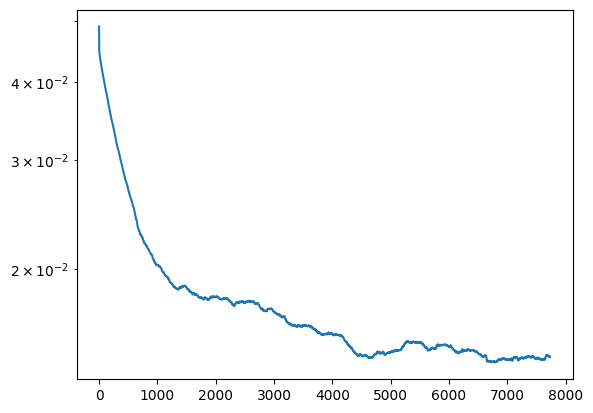

In [37]:
trainer.plot_loss()

## Visualize

In [38]:
input, target, final_states, input_index, task_context = vizualize(ca, jax.random.PRNGKey(45), columns=8, trial="test");

Traced<ShapedArray(int32[])>with<BatchTrace(level=1/0)> with
  val = Array([5, 8, 3, 7, 0, 7, 6, 8], dtype=int32)
  batch_dim = 0
Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([0.00753707, 0.10617888, 0.02017727, 0.11711624, 0.11710147,
       0.04219158, 0.22064182, 0.14705704], dtype=float32)
  batch_dim = 0


,,,,,,,


,,,,,,,


,,,,,,,


In [33]:
task_context[:, 2] * 180

Array([ 1.3566731, 19.112198 ,  3.6319077, 21.080923 , 21.078264 ,
        7.594484 , 39.715527 , 26.470268 ], dtype=float32)

In [26]:
task_context[:, 2] * 180

Array([ 6.0850673 ,  7.0702615 ,  0.65311784, 18.940317  , 16.200375  ,
        0.5080402 , 11.138094  ,  7.420397  ], dtype=float32)

In [ ]:
# save as pickle
import pickle
# pickle.dump(nnx.state(ca, nnx.Param), open("model.pkl", "wb"))

In [34]:
#  load as pickle
import pickle
model = pickle.load(open("model.pkl", "rb"))
nnx.update(ca, model)